In [20]:
import pandas as pd
import numpy as np
import torch
import sklearn
import matplotlib.pyplot as plt
import torchinfo, torchmetrics
import intel_extension_for_pytorch as ipex

torch.manual_seed(42)


(1460, 1306)

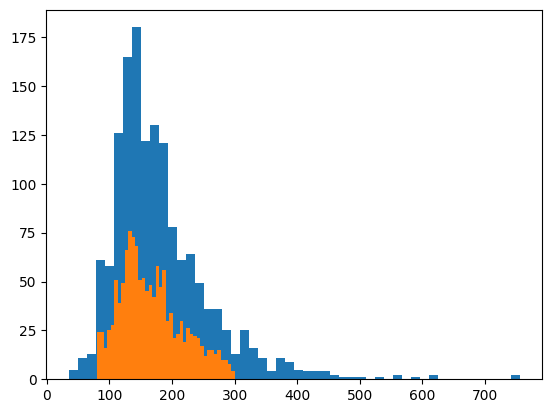

In [21]:
data = pd.read_csv('data/house-prices.csv')
data = data.set_index('Id')
naive_data = data.select_dtypes(exclude = ['object'])
plt.hist(naive_data.SalePrice, bins=50)
naive_data = naive_data[(naive_data.SalePrice > 80) & (naive_data.SalePrice < 300)]
plt.hist(naive_data.SalePrice, bins=40)
len(data),len(naive_data)

This was or output for the best XGBoostRegressor model:

    Train dataset
    R2 score: 0.9992
    MSE score: 5.3522
    MAE score: 1.6777

    Validation dataset
    R2 score: 0.8493
    MSE score: 803.4069
    MAE score: 15.9140
    
    Test dataset
    R2 score: 0.9023
    MSE score: 583.1461
    MAE score: 15.7232

Let us see what we can do now with Neural Networks.

In [45]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torchmetrics import R2Score, MeanSquaredError
from torchmetrics.functional import mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(naive_data.drop(columns=['SalePrice']),naive_data['SalePrice'],
                                                    train_size=0.7,
                                                   random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5,random_state=123)

# Rescale
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# convert into torch tensors
X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train.values).type(torch.float)
X_val = torch.from_numpy(X_val).type(torch.float)
y_val = torch.from_numpy(y_val.values).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test.values).type(torch.float)


def performance_report(model) -> None:
    datasets = [[X_train, y_train],[X_val, y_val],[X_test, y_test]]
    dataset_names = ['Train','Validation','Test']
    
    for dataset in enumerate(datasets):
        with torch.inference_mode():
            preds = model(dataset[1][0])
            target = dataset[1][1]
            r2 = R2Score()
            MSE = MeanSquaredError()
            MAE = mean_absolute_error(preds, target)
            print(f"\n{dataset_names[dataset[0]]} dataset")
            print(f'R2 score: {r2(preds, target):.4f}')
            print(f'MSE score: {MSE(preds,target):.4f}')
            print(f'MAE score: {MAE:.4f}')


X_train.shape

torch.Size([914, 34])

In [58]:
from torch import nn

class RegressionNN(nn.Module):
    def __init__(self, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=X_train.shape[1], out_features=hidden_units),
            nn.ELU(), 
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ELU(),
            nn.Linear(in_features=hidden_units, out_features=1), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

regnn = RegressionNN(hidden_units = 64)

In [59]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(regnn.parameters(), lr=0.001)

In [60]:
# Set the number of epochs
epochs = 1000

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    regnn.train()
    y_pred = regnn(X_train).squeeze(dim=1)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    regnn.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = regnn(X_test).squeeze(dim=1)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")



Epoch: 0 | Train loss: 168.17717, Test loss: 159.82803
Epoch: 100 | Train loss: 138.71547, Test loss: 129.67938
Epoch: 200 | Train loss: 29.46939, Test loss: 28.70688
Epoch: 300 | Train loss: 17.22162, Test loss: 20.00961
Epoch: 400 | Train loss: 13.28092, Test loss: 16.87247
Epoch: 500 | Train loss: 11.23778, Test loss: 15.69242
Epoch: 600 | Train loss: 9.93622, Test loss: 15.23883
Epoch: 700 | Train loss: 9.05322, Test loss: 14.99982
Epoch: 800 | Train loss: 8.43981, Test loss: 14.94032
Epoch: 900 | Train loss: 7.95592, Test loss: 14.97551


In [61]:
def performance_report(model) -> None:
    datasets = [[X_train, y_train],[X_val, y_val],[X_test, y_test]]
    dataset_names = ['Train','Validation','Test']
    
    for dataset in enumerate(datasets):
        with torch.inference_mode():
            preds = model(dataset[1][0]).squeeze(dim=1)
            target = dataset[1][1]
            r2 = R2Score()
            MSE = MeanSquaredError()
            MAE = mean_absolute_error(preds, target)
            print(f"\n{dataset_names[dataset[0]]} dataset")
            print(f'R2 score: {r2(preds, target):.4f}')
            print(f'MSE score: {MSE(preds,target):.4f}')
            print(f'MAE score: {MAE:.4f}')

performance_report(regnn)


Train dataset
R2 score: 0.9231
MSE score: 195.6441
MAE score: 7.5233

Validation dataset
R2 score: 0.3810
MSE score: 1560.0316
MAE score: 17.9325

Test dataset
R2 score: 0.8062
MSE score: 409.8244
MAE score: 15.1128


# Second example

In [72]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=123)

In [73]:
# Scaling and making it into a Tensor
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)
X_train.shape[1]

13

In [74]:
class BostonRegressionNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(13, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

boston_model = BostonRegressionNN()

In [75]:
# Reproducible results
torch.manual_seed(42)

In [76]:
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(boston_model.parameters(), lr=2e-4)

In [77]:
# Run the training loop
# Set the number of epochs
epochs = 5000

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    boston_model.train()
    y_pred = boston_model(X_train).squeeze(dim=1)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    boston_model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = boston_model(X_test).squeeze(dim=1)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 500 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Train loss: 22.53928, Test loss: 22.85912
Epoch: 500 | Train loss: 6.37117, Test loss: 6.21169
Epoch: 1000 | Train loss: 3.08625, Test loss: 3.32651
Epoch: 1500 | Train loss: 2.34721, Test loss: 2.79183
Epoch: 2000 | Train loss: 2.03500, Test loss: 2.68008
Epoch: 2500 | Train loss: 1.85044, Test loss: 2.65589
Epoch: 3000 | Train loss: 1.71986, Test loss: 2.65217
Epoch: 3500 | Train loss: 1.60232, Test loss: 2.63512
Epoch: 4000 | Train loss: 1.50205, Test loss: 2.62947
Epoch: 4500 | Train loss: 1.42492, Test loss: 2.61908


In [78]:
def performance_report(model) -> None:
    datasets = [[X_train, y_train],[X_test, y_test]]
    dataset_names = ['Train','Test']
    
    for dataset in enumerate(datasets):
        with torch.inference_mode():
            preds = model(dataset[1][0]).squeeze(dim=1)
            target = dataset[1][1]
            r2 = R2Score()
            MSE = MeanSquaredError()
            MAE = mean_absolute_error(preds, target)
            print(f"\n{dataset_names[dataset[0]]} dataset")
            print(f'R2 score: {r2(preds, target):.4f}')
            print(f'MSE score: {MSE(preds,target):.4f}')
            print(f'MAE score: {MAE:.4f}')

performance_report(boston_model)


Train dataset
R2 score: 0.9202
MSE score: 6.8777
MAE score: 1.3607

Test dataset
R2 score: 0.7579
MSE score: 19.1102
MAE score: 2.5959


# Third Example: The California Dataset

This is a dataset that describes the median house value for California districts. Each data sample is a census block group. The target variable is the median house value in USD 100,000 in 1990 and there are 8 input features, each describing something about the house. They are, namely,

- MedInc: median income in block group
- HouseAge: median house age in block group
- AveRooms: average number of rooms per household
- AveBedrms: average number of bedrooms per household
- Population: block group population
- AveOccup: average number of household members
- Latitude: block group centroid latitude
- Longitude: block group centroid longitude


In [79]:
#!pip install tqdm
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

# Read data
data = fetch_california_housing()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=123)

# Convert to PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


In [80]:
# Define the model (simpler version)
#model = nn.Sequential(
#    nn.Linear(8, 24),
#    nn.ReLU(),
#    nn.Linear(24, 12),
#    nn.ReLU(),
#    nn.Linear(12, 6),
#    nn.ReLU(),
#    nn.Linear(6, 1)
#)

# More elegant version 
class CaliforniaRegressionNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(8, 24),
        nn.ReLU(),
        nn.Linear(24, 12),
        nn.ReLU(),
        nn.Linear(12, 6),
        nn.ReLU(),
        nn.Linear(6, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

cali_model = CaliforniaRegressionNN()

In [81]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(cali_model.parameters(), lr=0.0001)

MSE: 0.54
RMSE: 0.73


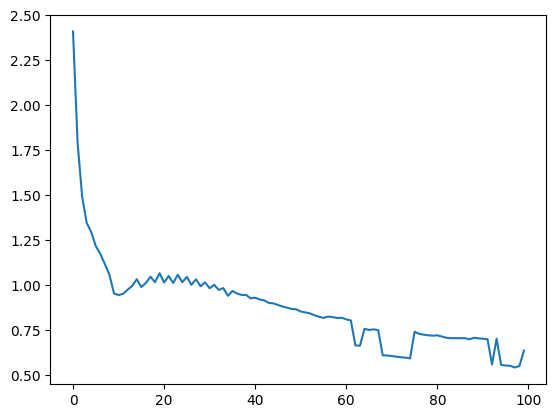

In [82]:
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    cali_model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = cali_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    cali_model.eval()
    y_pred = cali_model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(cali_model.state_dict())

# restore model and return best accuracy
cali_model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [83]:
def performance_report(model) -> None:
    datasets = [[X_train, y_train],[X_test, y_test]]
    dataset_names = ['Train','Test']
    
    for dataset in enumerate(datasets):
        with torch.inference_mode():
            preds = model(dataset[1][0])
            target = dataset[1][1]
            r2 = R2Score()
            MSE = MeanSquaredError()
            MAE = mean_absolute_error(preds, target)
            print(f"\n{dataset_names[dataset[0]]} dataset")
            print(f'R2 score: {r2(preds, target):.4f}')
            print(f'MSE score: {MSE(preds,target):.4f}')
            print(f'MAE score: {MAE:.4f}')

performance_report(cali_model)


Train dataset
R2 score: 0.5845
MSE score: 0.5548
MAE score: 0.5492

Test dataset
R2 score: 0.5919
MSE score: 0.5396
MAE score: 0.5434
